/tmp/ipykernel_67/371008040.py:105: RuntimeWarning: divide by zero encountered in divide
  cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2)
/tmp/ipykernel_67/371008040.py:108: RuntimeWarning: invalid value encountered in divide
  cosmic_ray = cosmic_ray / cosmic_ray.max()


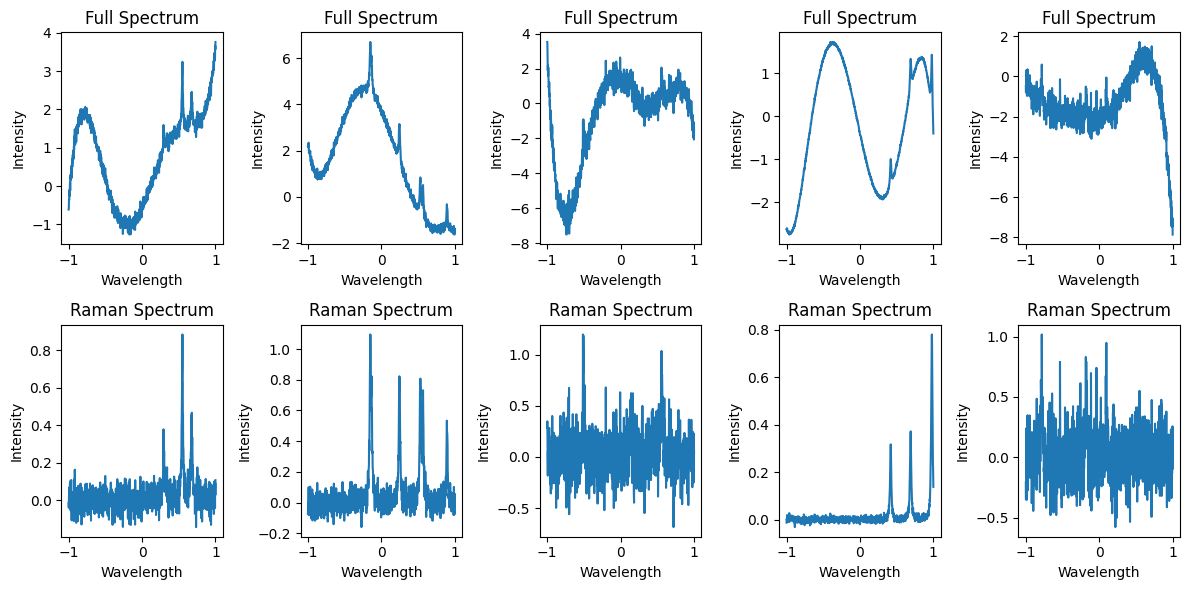

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 1. INPUT PARAMETERS
class SyntheticRamanSpectrum:
    def __init__(self, pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra):
        self.pixels = pixels
        self.poly_order_range = poly_order_range
        self.num_peaks_range = num_peaks_range
        self.snr_range = snr_range
        self.cosmic_ray_prob = cosmic_ray_prob
        self.num_spectra = num_spectra
        self.wavelengths = np.linspace(-1, 1, self.pixels)
        self.full_spectra_list = []
        self.raman_spectra_list = []

    # 2. CHEBYSHEV BASELINE    
    def chebyshev_polynomial(self, x, *coefficients):
        order = len(coefficients)
        chebyshev_vals = np.zeros_like(x)
    
        for i in range(order):
            chebyshev_vals += coefficients[i] * np.cos(i * np.arccos(np.array(x)))
     
        return chebyshev_vals
    
    def generate_spectrum(self):
        # Randomly select polynomial order for Chebyshev baseline
        poly_order = np.random.randint(self.poly_order_range[-1], self.poly_order_range[1] + 1)

        # Initialize an empty array to store the Chebyshev coefficients
        cheby_baseline_coefficients = np.random.uniform(-1, 1, poly_order + 1)

        # Generate Chebyshev coefficients iteratively
        for i in range(poly_order + 1):
            cheby_baseline_coefficients[i] = np.random.uniform(-1, 1)

        # Generate Chebyshev baseline
        self.cheby_baseline = self.chebyshev_polynomial(self.wavelengths, *cheby_baseline_coefficients)
    
    # 3. LORENTZIAN PEAKS
    def add_lorentzian_peaks(self):
        # Define parameters for Lorentzian peaks
        num_peaks = np.random.randint(self.num_peaks_range[0], self.num_peaks_range[1] + 1)
        peak_amplitudes = np.random.uniform(0, 1, num_peaks)
        peak_positions = np.random.uniform(-1, 1, num_peaks)
        peak_width = 1 / (self.pixels * 0.1)

        # Initialize peaks array
        peaks = np.zeros_like(self.wavelengths)

        # Add Lorentzian peaks to spectrum
        for i in range(num_peaks):
            peaks += peak_amplitudes[i] * (peak_width ** 2) / ((self.wavelengths - peak_positions[i]) ** 2 + peak_width ** 2)

        # Update peaks attribute
        self.peaks = peaks

        # Add peaks to Chebyshev baseline
        self.peaky_cheby = self.peaks + self.cheby_baseline
    
    # 4. NOISE GENERATION
    def add_gaussian_noise(self, noise_amplitude_range=(0, 1)):
        # Calculate signal power
        signal_power = np.mean(np.abs(self.cheby_baseline + self.peaks) ** 2)

        # Calculate noise power based on SNR
        noise_power = signal_power / self.snr_range

        # Calculate standard deviation of noise
        noise_std = np.sqrt(noise_power)

        # Generate random noise amplitudes within specified range
        min_amp, max_amp = noise_amplitude_range
        noise_amplitudes = np.random.uniform(min_amp, max_amp)

        # Generate Gaussian noise samples
        noise = np.random.normal(0, noise_std, len(self.wavelengths))

        # Scale noise by noise amplitudes
        total_noise = noise * noise_amplitudes
        
        # Add noise to peaky cheby spectra
        self.noisy_peaky_cheby = self.peaky_cheby + total_noise

    # 5. COSMIC RAYS
    # Generate Cosmic Rays 
    # Lorentzian peak with a width of 0, y = 1 / (x - position)^2  
    # Cosmic ray amplitudes: randomized between 0.8 & L2-norm of complete signal

    def add_cosmic_rays(self, num_cosmic_rays):
        cosmic_rays_spectrum = self.noisy_peaky_cheby.copy()
    
        # Calculate L2-norm of complete signal
        l2_norm = np.linalg.norm(cosmic_rays_spectrum)
    
        for _ in range(num_cosmic_rays):
            # Generate random amplitude between 0.8 and the L2-norm of the complete signal
            cosmic_ray_amplitude = np.random.uniform(0.8, l2_norm)
        
            # Randomly select position for cosmic ray
            position = np.random.randint(0, len(cosmic_rays_spectrum))
        
            # Create cosmic ray using y = 1 / (x - position)^2  
            cosmic_ray = cosmic_ray_amplitude / ((self.wavelengths - self.wavelengths[position]) ** 2)

            # Normalize cosmic ray
            cosmic_ray = cosmic_ray / cosmic_ray.max()

            # Add cosmic ray to spectrum
            cosmic_rays_spectrum += cosmic_ray

        # Update full synthetic spectrum with cosmic rays
        full_spectrum = cosmic_rays_spectrum + self.noisy_peaky_cheby
        self.full_spectra_list.append(full_spectrum)

        # Update the Raman spectrum (only peaks) with cosmic rays
        raman_spectrum = cosmic_rays_spectrum - self.cheby_baseline
        self.raman_spectra_list.append(raman_spectrum)

# Parameters
pixels = 1024
poly_order_range = (2, 5)
num_peaks_range = (3, 6)
snr_range = 20
cosmic_ray_prob = 0.1
num_spectra = 5

synthetic_data_generator = SyntheticRamanSpectrum(pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra)

# Generate synthetic spectra
for _ in range(num_spectra):
    # Randomly sample parameter values within specified ranges
    synthetic_data_generator.generate_spectrum()
    synthetic_data_generator.add_lorentzian_peaks()
    synthetic_data_generator.add_gaussian_noise()
    
    # Generate a random number of cosmic rays between 0 and 5
    num_cosmic_rays = np.random.randint(0, 6)
    synthetic_data_generator.add_cosmic_rays(num_cosmic_rays)

full_spectra = synthetic_data_generator.full_spectra_list    # full_spectra = full synthetic measured spectra
raman_spectra = synthetic_data_generator.raman_spectra_list  # raman_spectra = only Raman signals

# Visualize results
plt.figure(figsize=(12, 6))

num_plots = min(5, num_spectra)

# Plot full synthetic spectra
for i in range(num_plots):
    plt.subplot(2, num_plots, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, full_spectra[i])
    plt.title('Full Spectrum')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

# Plot Raman spectra
for i in range(num_plots):
    plt.subplot(2, num_plots, i + num_plots + 1)
    plt.plot(synthetic_data_generator.wavelengths, raman_spectra[i])
    plt.title('Raman Spectrum')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

plt.tight_layout()
plt.show()

In [3]:
# A) CALCULATE SD from SNR for ZERO-MEAN GAUSSIAN DISTRIBUTION
# A.1) Convert SNR to Linear Scale (SNR linear = 10^(SNR_target/10))

# Given SNR in dB
SNR_dB = snr_range

# Convert SNR to linear scale
SNR_linear = 10 ** (SNR_dB / 10)

print(f"SNR (linear scale): {SNR_linear}")

SNR (linear scale): 100.0


In [4]:
# A.2) Calculate Variance (V = 1/SNR linear)

# Variance using formula
variance = 1 / SNR_linear

print(f"Variance: {variance}")

Variance: 0.01


In [5]:
# A.3) Calculate Standard Deviation (σ = √Variance)
import numpy as np

# Calculate the standard deviation
std_deviation = np.sqrt(variance)

print(f"Standard Deviation: {std_deviation}")

Standard Deviation: 0.1


In [6]:
# B) GENERATE CHEBYSHEV POLYNOMIALS 
# B.1) Define Parameters

# Set maximum polynomial order n
n = 5

# Create an array of x values (-1 to 1) to evaluate polynomials
x_values = np.linspace(-1, 1, 100)

x_values

array([-1.        , -0.97979798, -0.95959596, -0.93939394, -0.91919192,
       -0.8989899 , -0.87878788, -0.85858586, -0.83838384, -0.81818182,
       -0.7979798 , -0.77777778, -0.75757576, -0.73737374, -0.71717172,
       -0.6969697 , -0.67676768, -0.65656566, -0.63636364, -0.61616162,
       -0.5959596 , -0.57575758, -0.55555556, -0.53535354, -0.51515152,
       -0.49494949, -0.47474747, -0.45454545, -0.43434343, -0.41414141,
       -0.39393939, -0.37373737, -0.35353535, -0.33333333, -0.31313131,
       -0.29292929, -0.27272727, -0.25252525, -0.23232323, -0.21212121,
       -0.19191919, -0.17171717, -0.15151515, -0.13131313, -0.11111111,
       -0.09090909, -0.07070707, -0.05050505, -0.03030303, -0.01010101,
        0.01010101,  0.03030303,  0.05050505,  0.07070707,  0.09090909,
        0.11111111,  0.13131313,  0.15151515,  0.17171717,  0.19191919,
        0.21212121,  0.23232323,  0.25252525,  0.27272727,  0.29292929,
        0.31313131,  0.33333333,  0.35353535,  0.37373737,  0.39

In [7]:
# B.2) Initialize Matrix

# Create an empty matrix to store Chebyshev polynomials
chebyshev_matrix = np.zeros((n + 1, len(x_values)))

# Initialize first two rows of matrix
chebyshev_matrix[0] = np.ones(len(x_values))  # T0(x) = 1
chebyshev_matrix[1] = x_values                # T1(x) = x

chebyshev_matrix
chebyshev_matrix[0]
chebyshev_matrix[1]

array([-1.        , -0.97979798, -0.95959596, -0.93939394, -0.91919192,
       -0.8989899 , -0.87878788, -0.85858586, -0.83838384, -0.81818182,
       -0.7979798 , -0.77777778, -0.75757576, -0.73737374, -0.71717172,
       -0.6969697 , -0.67676768, -0.65656566, -0.63636364, -0.61616162,
       -0.5959596 , -0.57575758, -0.55555556, -0.53535354, -0.51515152,
       -0.49494949, -0.47474747, -0.45454545, -0.43434343, -0.41414141,
       -0.39393939, -0.37373737, -0.35353535, -0.33333333, -0.31313131,
       -0.29292929, -0.27272727, -0.25252525, -0.23232323, -0.21212121,
       -0.19191919, -0.17171717, -0.15151515, -0.13131313, -0.11111111,
       -0.09090909, -0.07070707, -0.05050505, -0.03030303, -0.01010101,
        0.01010101,  0.03030303,  0.05050505,  0.07070707,  0.09090909,
        0.11111111,  0.13131313,  0.15151515,  0.17171717,  0.19191919,
        0.21212121,  0.23232323,  0.25252525,  0.27272727,  0.29292929,
        0.31313131,  0.33333333,  0.35353535,  0.37373737,  0.39

In [8]:
# B.3) Generate Polynomials

# Loop from i = 2 to n
for i in range(2, n + 1):
    # Compute i-th Chebyshev polynomial using recursive formula
    ti_minus_1 = chebyshev_matrix[i - 1]  # Ti-1(x)
    ti_minus_2 = chebyshev_matrix[i - 2]  # Ti-2(x)
    
    ti = 2 * x_values * ti_minus_1 - ti_minus_2     # Ti(x) = 2 * x * Ti-1(x) - Ti-2(x)
    
    # Store computed polynomial values in i-th row of matrix
    chebyshev_matrix[i] = ti
    
chebyshev_matrix

array([[ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1. 